In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error ,r2_score, mean_squared_log_error,mean_absolute_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from scipy.stats import norm, skew
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

In [46]:
testdata_pro = pd.read_csv('../Data/testdata_preprocessed_1.csv')
dataframe = pd.read_csv('../Data/new_data_preprocessed_2.csv')

In [47]:
testdata = pd.read_csv('../Data/test.csv')
ID = testdata[['ID']]

In [48]:
X=dataframe.drop('cc_cons',1)
y=dataframe[['cc_cons']].copy()

In [49]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [50]:
def rmsle(actual_column, predicted_column):
    sum=0.0
    for x,y in zip(actual_column,predicted_column):
        if x<0 or y<0: #check for negative values. 
            continue
        p = np.log(y+1)
        r = np.log(x+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted_column))**0.5

In [52]:
#Baseline models: 

def run_model(X,y,model):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)    
    X_train_s = x_scaler.fit_transform(X_train)
    X_test_s = x_scaler.fit_transform(X_test)
    y_train_s = y_scaler.fit_transform(y_train)
    y_test_s = y_scaler.fit_transform(y_test)
    testdata_pro_s = x_scaler.fit_transform(testdata_pro)
    model.fit(X_train_s,y_train_s)
    
    #predict on preprocessed test file
    y_pred_test = model.predict(testdata_pro_s)
    root_mean_squared_log = rmsle(y_test_s,y_pred_test)
    return root_mean_squared_log,y_pred_test

models = {'Linear Regression':LinearRegression,'Ridge':Ridge,'Lasso': Lasso,'Decision Tree':DecisionTreeRegressor, 'Random Forest':RandomForestRegressor}

for i in models.items():
    # run model
    model = i[1]()
    metric,y_predicted = run_model(X, y, model) # train and returns AUC test score
    print('RMSLE Score= '+str(metric) +'\nOn Model '+str(i[0]))
    print('**'*20)

RMSLE Score= [0.13456991]
On Model Linear Regression
****************************************
RMSLE Score= [0.13457075]
On Model Ridge
****************************************
RMSLE Score= [0.13430754]
On Model Lasso
****************************************
RMSLE Score= [0.20108506]
On Model Decision Tree
****************************************
RMSLE Score= [0.1490007]
On Model Random Forest
****************************************


In [53]:
y_predicted_scaled = y_scaler.inverse_transform(y_predicted.reshape(-1,1))

In [54]:
y_predicted_scaled

array([[286.88833939],
       [144.85117954],
       [124.59477394],
       ...,
       [146.88333699],
       [194.40200981],
       [193.21006852]])

In [55]:
np.square(y_predicted_scaled)

array([[82304.91928055],
       [20981.8642134 ],
       [15523.85769428],
       ...,
       [21574.71468581],
       [37792.14141957],
       [37330.13057818]])

In [38]:
lasso = Lasso()
lasso_rmsle = run_model(X,y,lasso)
(lasso.coef_)

array([-0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.])

In [49]:
from sklearn.feature_selection import RFE
nof_list=[39,36,32,28,24,20,16,12,8,4]
low_score=1
nof=0
models = {'Linear Regression':LinearRegression,'Ridge':Ridge,'Lasso': Lasso,'Decision Tree':DecisionTreeRegressor, 'Random Forest':RandomForestRegressor,'XGBoost':XGBRegressor}

for i in models.items():
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
    for n in nof_list:
        model = i[1]()
        model.fit(X_train,y_train)
        rfe=RFE(model,n)
        X_train_rfe=rfe.fit_transform(X_train,y_train)
        X_test_rfe=rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        y_pred = model.predict(X_test_rfe)
        rmsle=np.sqrt(mean_squared_log_error(y_test,y_pred))
        if rmsle<low_score:
            low_score=rmsle
            nof=n
    print('Lowest Score, i.e lowest rmsle for model {} is {}'.format(str(i[0]),low_score))
    print('No of features: ',nof)
# print(X.shape)
# print(X.columns)
# lr=LinearRegression()
# lr.fit(X_train,y_train)
# print('Score without RFE: ',lr.score(X_test,y_test))
# print(rfe.support_)

Lowest Score, i.e lowest rmsle for model Linear Regression is 0.08116742108738613
No of features:  4
Lowest Score, i.e lowest rmsle for model Ridge is 0.08116742108738613
No of features:  4
Lowest Score, i.e lowest rmsle for model Lasso is 0.08115034126612419
No of features:  39
Lowest Score, i.e lowest rmsle for model Decision Tree is 0.08115034126612419
No of features:  39
Lowest Score, i.e lowest rmsle for model Random Forest is 0.08115034126612419
No of features:  39
[19:53:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:06] WARNING: C:/Jenkins/w

[19:56:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:43] WARNI

[19:58:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:55] WARNI

[20:00:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:02] WARNI

[20:02:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Lowest Score, i.e lowest rmsle for model XGBoost is 0.08115034126612419
No of features:  39


In [44]:
def feature_selection(X,y,number_of_features,model):
    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
#     print(feature_ranking)
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('**'*30)

models = {'Linear Regression':LinearRegression,'Decision Tree':DecisionTreeRegressor, 'Random Forest':RandomForestRegressor,'XGBoost':XGBRegressor}
for i in models.items():
    feature_selection(X,y,20,i[1])

Features  to be selected for Linear Regression are:
['age', 'region_code', 'cc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_may', 'cc_count_jun', 'dc_count_may', 'card_lim', 'investment_3', 'investment_4', 'credit_amount_apr', 'debit_count_apr', 'max_credit_amount_apr', 'credit_amount_may', 'credit_amount_jun', 'max_credit_amount_jun', 'emi_active']
Features  to be selected for Decision Tree are:
['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'max_credit_amount_jun', 'emi_active']
Features  to be selected for Random Forest are:
['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'card_lim', 'investment_1', 'investment_2', 'investment_3'

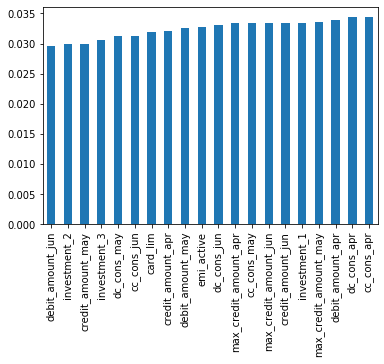

Features Selected by Random Forest method are:
 ['debit_amount_jun', 'investment_2', 'credit_amount_may', 'investment_3', 'dc_cons_may', 'cc_cons_jun', 'card_lim', 'credit_amount_apr', 'debit_amount_may', 'emi_active', 'dc_cons_jun', 'max_credit_amount_apr', 'cc_cons_may', 'max_credit_amount_jun', 'credit_amount_jun', 'investment_1', 'max_credit_amount_may', 'debit_amount_apr', 'dc_cons_apr', 'cc_cons_apr']


In [53]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42) 
    rfc = RandomForestRegressor(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values()
    rfc_importances.plot(kind='bar')
    plt.show()
    selected_features = list(rfc_importances.index)
    print('Features Selected by Random Forest method are:\n',selected_features)

rfc_feature_selection(X,y)

In [56]:
parameter_grid={'max_depth':[3,None],
           'max_features':[5,10,15,20,25,30],
           "bootstrap": [True, False]}
rf_clf=RandomForestRegressor(random_state=0)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train_s = x_scaler.fit_transform(X_train)
X_test_s = x_scaler.fit_transform(X_test)
y_train_s = y_scaler.fit_transform(y_train)
y_test_s = y_scaler.fit_transform(y_test)
testdata_pro_s = x_scaler.fit_transform(testdata_pro)
grid_search = GridSearchCV(rf_clf,param_grid=parameter_grid,cv=5,n_jobs=10,verbose=20)
grid_search.fit(X_train_s,y_train_s)
grid_pred_test=grid_search.predict(testdata_pro_s)
# grid_roc_score=roc_auc_score(grid_pred,y_test)
grid_search_score=rmsle(y_test_s,grid_pred_test)
print(grid_search_score)
# print('Best_parameters_are : ',grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   32.7s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   33.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   33.2s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   33.4s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   33.4s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[0.13447233]


In [57]:
grid_pred_test_t = y_scaler.inverse_transform(grid_pred_test.reshape(-1,1))
grid_pred_test_t

array([[173.49997635],
       [173.19011073],
       [172.26195849],
       ...,
       [170.36191846],
       [173.96156232],
       [178.53505183]])

In [58]:
grid_pred_test_t = np.square(grid_pred_test_t)
np.max(grid_pred_test_t)

86145.3667187094

In [63]:
prediction = pd.DataFrame(grid_pred_test_t,columns=['cc_cons'])
submission_trial = pd.concat([ID,prediction['cc_cons']],1)

In [65]:
submission_trial.to_csv('../Data/submission.csv',index=False)